In [1]:
from collections import defaultdict

import core.history as ch
import core.fine_model as cm
from core.fine_model import FineModel

import cr_interface as cri
import keras_utils as ku

from keras.optimizers import *
import pandas as pd

import math
import shutil

Using TensorFlow backend.


In [2]:
models = FineModel.get_dict()
models.keys()
#dict_keys(['xception', 'mobileneta25', 'mobilenetv2a35', 'vgg16', 'resnet50v2',
#'inception_v3','inception_resnet_v2', 'densenet121', 'nasnet_mobile'])
fm = models['mobileneta25']()

aug_gen = fm.get_image_data_generator(augment=True)
pure_gen = fm.get_image_data_generator(augment=False)

In [3]:
train = cri.CrCollection.load().filter_by(dataset_index=0).tri_label().labeled().sample(frac=0.1)
test = cri.CrCollection.load().filter_by(dataset_index=1).tri_label().labeled().sample(frac=0.1)

In [4]:
BATCH_SIZE = 32
train_dir = 'temp_images/train'
test_dir = 'temp_images/test'
shutil.rmtree(train_dir)
shutil.rmtree(test_dir)

train.export_by_label(train_dir)
test.export_by_label(test_dir)
train_gen = aug_gen.flow_from_directory(
    train_dir,
    target_size=fm.get_output_shape(),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_gen = pure_gen.flow_from_directory(
    test_dir,
    target_size=fm.get_output_shape(),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 512 images belonging to 3 classes.
Found 282 images belonging to 3 classes.


## Train & Save Weights

In [8]:
first = False
if first:
    fm.get_model()
    for i, depth in enumerate(fm.depths):
        fm.set_depth(i)
        fm.compile_model(optimizer=Adam())
        fm.get_model().fit_generator(
                train_gen,
                validation_data=test_gen,
                steps_per_epoch=math.ceil(train_gen.n / BATCH_SIZE),
                validation_steps=1,
                shuffle=True,
                epochs=5)
        fm.save_weights('D{:02d}'.format(i))

## Load Weights & Evaluate

In [9]:
depth = len(fm.depths) - 1
results = []
for i, depth in enumerate(fm.depths):
    fm.save_weights('new_exp')
    fm.load_weights('new_exp')  # mobilenet
    fm.load_weights('D{:02d}'.format(i))
    fm.compile_model()
    result = fm.get_model().evaluate_generator(
        test_gen,
        steps=len(test_gen)
    )
    print('LOSS: {} / ACC: {}'.format(*result))
    results.append(result)

Loading weights from /Users/itsnamgyu/Source/cardiac-research/core/.fine_model_weights/mobileneta25/D00.hd5...complete!
LOSS: 0.6889518178101127 / ACC: 0.6914893629703116
Loading weights from /Users/itsnamgyu/Source/cardiac-research/core/.fine_model_weights/mobileneta25/D01.hd5...complete!
LOSS: 1.1723617695747537 / ACC: 0.6382978714949695
Loading weights from /Users/itsnamgyu/Source/cardiac-research/core/.fine_model_weights/mobileneta25/D02.hd5...complete!
LOSS: 3.557862636890817 / ACC: 0.5425531923348177
Loading weights from /Users/itsnamgyu/Source/cardiac-research/core/.fine_model_weights/mobileneta25/D03.hd5...complete!
LOSS: 2.1875740145960596 / ACC: 0.5390070943122215
Loading weights from /Users/itsnamgyu/Source/cardiac-research/core/.fine_model_weights/mobileneta25/D04.hd5...complete!
LOSS: 4.4670048098192146 / ACC: 0.5212765957446809
Loading weights from /Users/itsnamgyu/Source/cardiac-research/core/.fine_model_weights/mobileneta25/D05.hd5...complete!
LOSS: 5.249772694093961 / 

In [10]:
acc_list = [acc for [loss, acc] in results]
loss_list = [loss for [loss, acc] in results]

history = pd.DataFrame(dict(
    depth=fm.depths,
    acc=acc_list,
    loss=loss_list
))

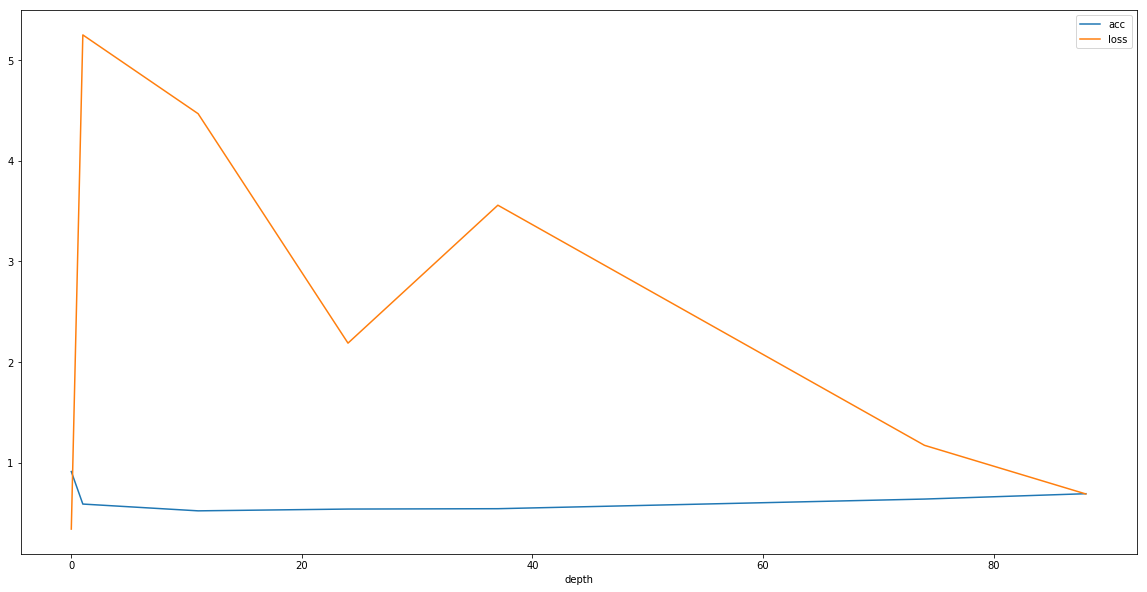

In [14]:
history.plot(x='depth', figsize=(20, 10))